In [ ]:
library(neuralnet)
library(kknn)
library(e1071)
library(partykit)
library(data.table)
library(future)
library(future.apply)
library(foreach)
library(doParallel)
library(doRNG)
library(mlr3learners)
library(mlr3)
library(mlr3pipelines)
library(mlr3tuning)
library(mlr3measures)
library(mlr3extralearners)

In [2]:
data <- read.csv("data60.csv", header = TRUE)
data[data == '?'] <- NA
data <- as.data.frame(lapply(data, as.numeric))
data <- na.omit(data)

n_targets <- 33
target_cols <- colnames(data[,(ncol(data) - n_targets + 1):ncol(data)])
data$target <- rowSums(data[,target_cols])
data <- data[,!(colnames(data) %in% c(target_cols, "ut_ms"))]
set.seed(1)
data <- data[sample(1:nrow(data), size = 1000, replace = FALSE),]
# drop features with near zero variance
data <- data[,!(names(data) %in% names(data)[apply(data, 2, var) < 0.5])]

# Evalvacija modelov

## KNN - Regresija
Izbrani parametri modela (grid search):

 * k = 10
 * razdalja : Manhattan
 * utežen vplit najbližnjih sosedov : optimal

## Neuronske mreže
Parametri:

* hidden layer size : (10, 10)
* learning rate : 0.01
* L2 regularizacija : 0.001

## Odločitvena drvesa
Parametri:

* min_samples_split : 20
* min_samples_leaf : 10
* max_depth : 5

## Metoda podpornih vektorjev
Parametri:

* kernel : rbf
* C : 1
* epsilon : 0.1

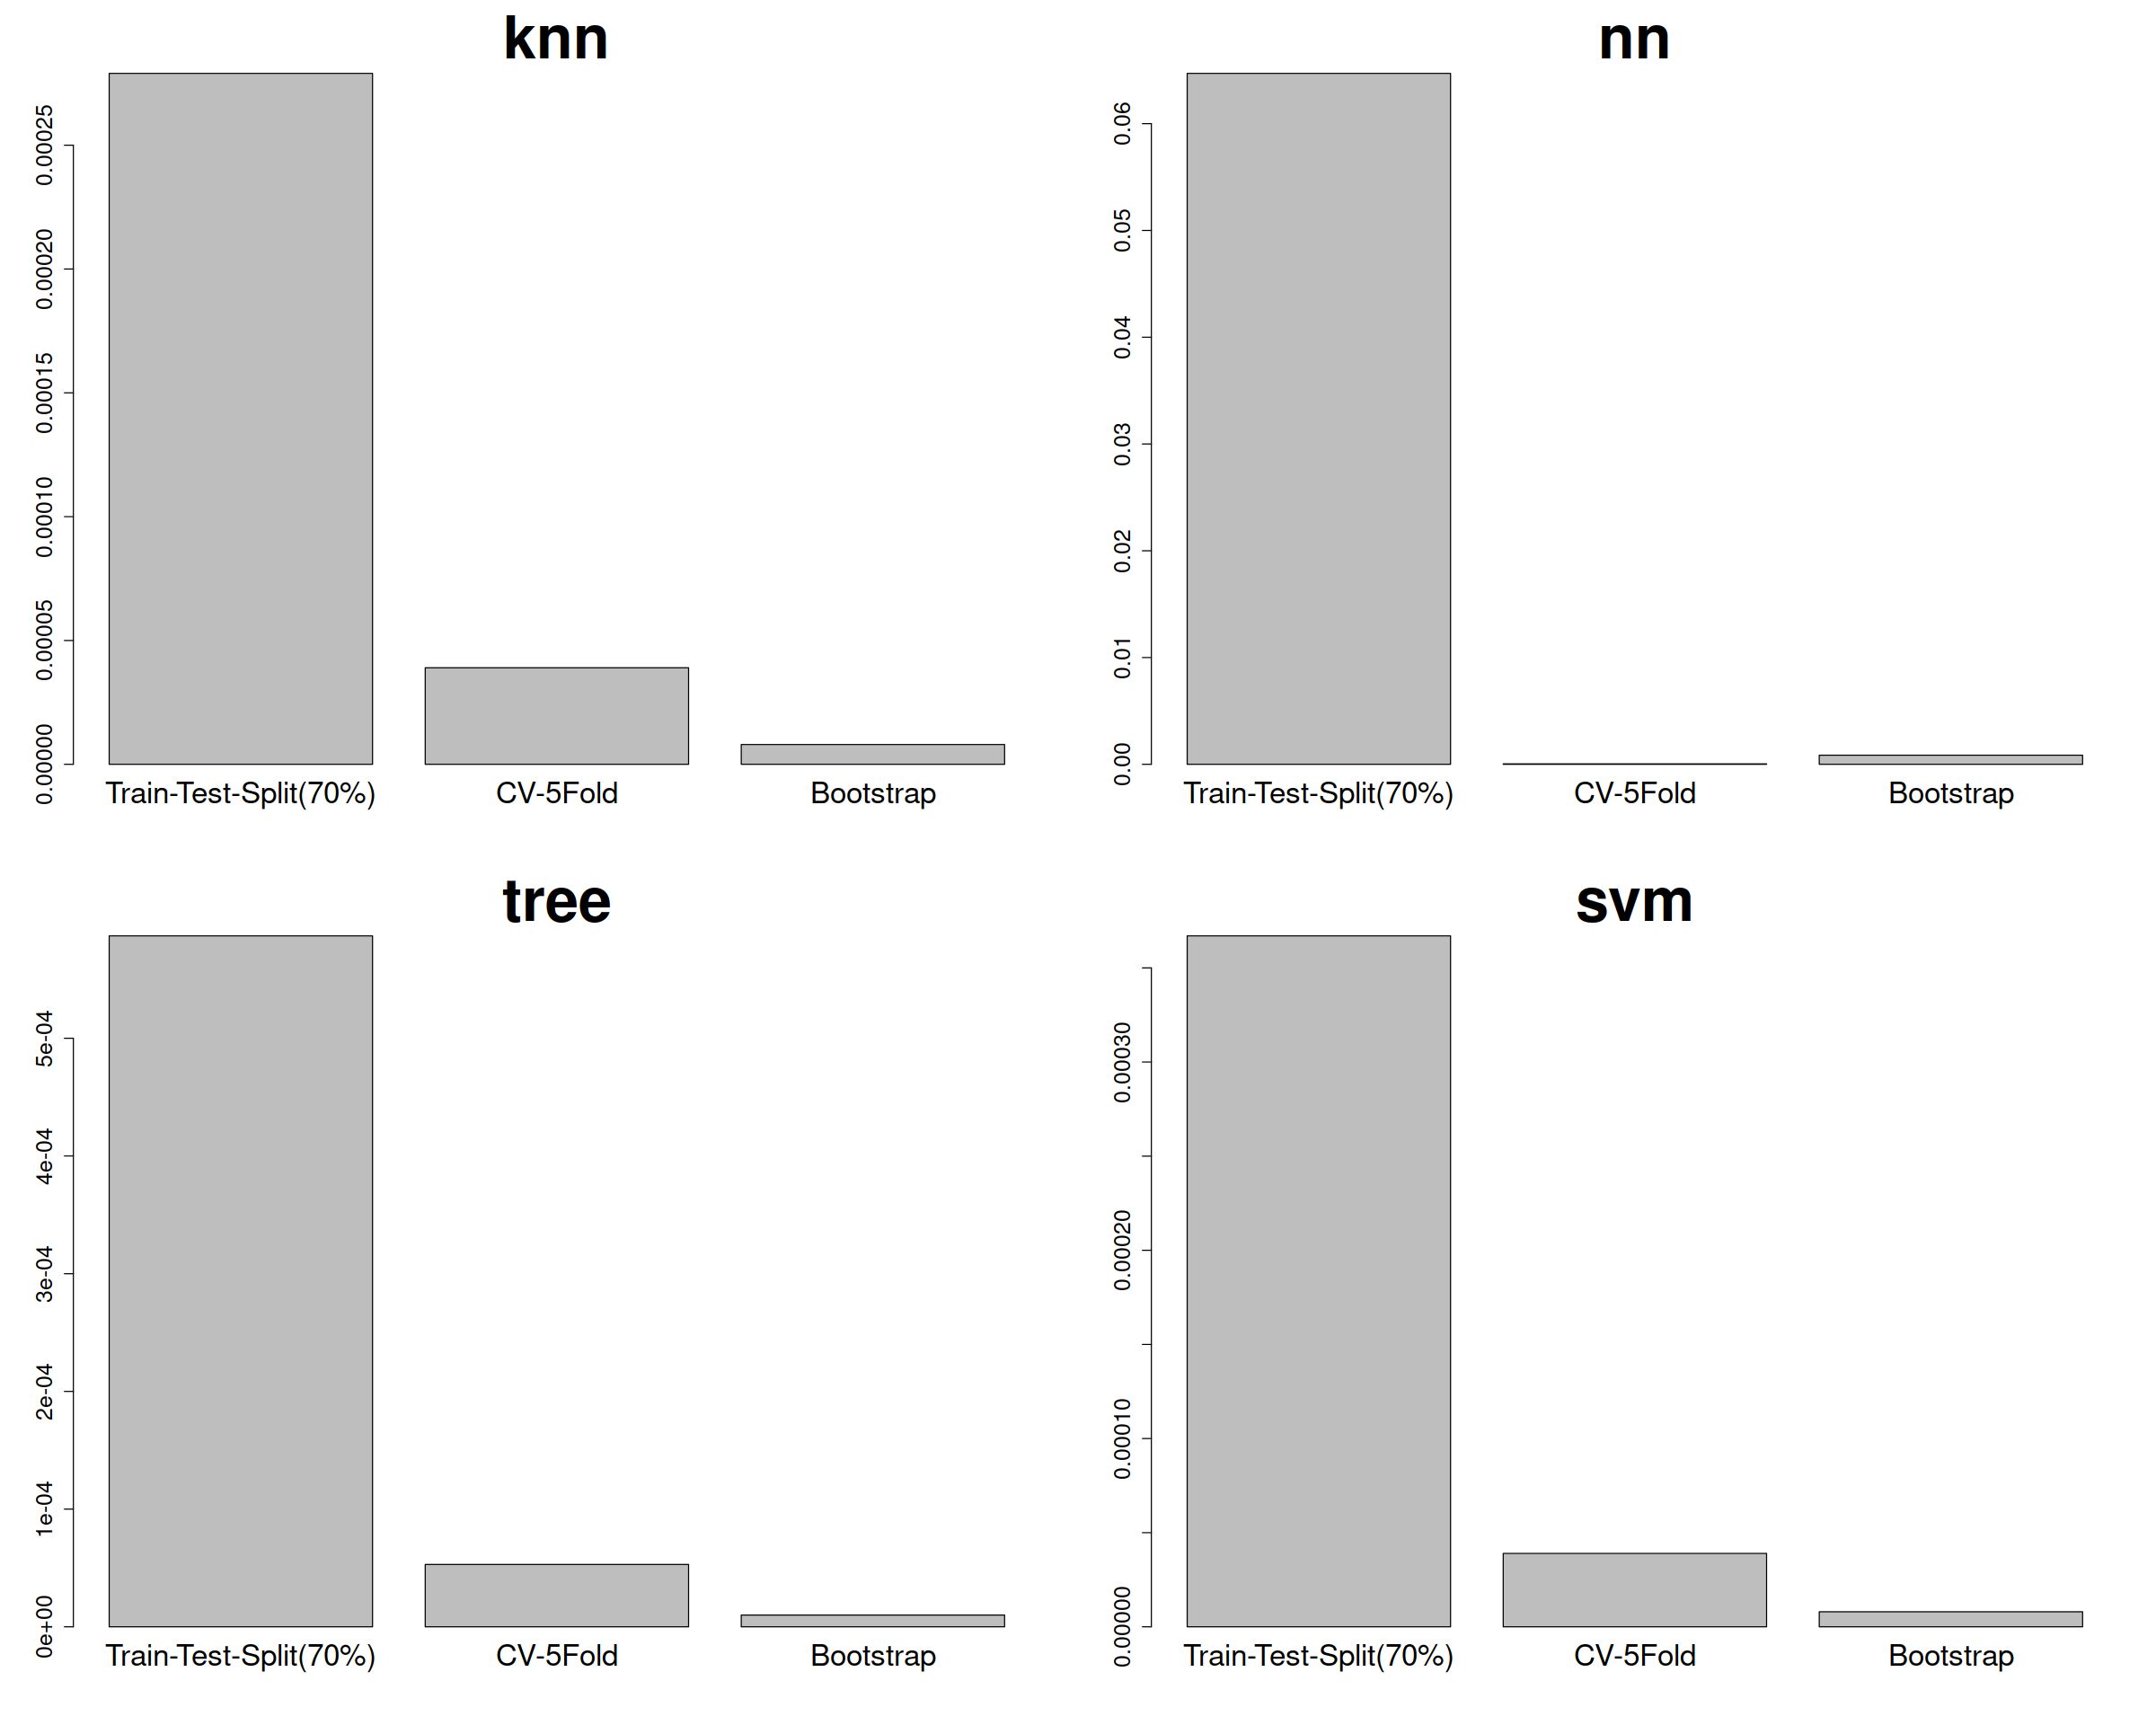

In [81]:
options(repr.plot.width=20, repr.plot.height=16)
par(mfrow=c(2,2))
for(name in c("knn", "nn", "tree", "svm")){
    barplot(
        height=c(
            train_test_results_agg['var',name], 
            cv_results_agg['var',name], 
            bootstrap_results_agg['var',name]),
        names=c(
            "Train-Test-Split(70%)",
            "CV-5Fold",
            "Bootstrap"),
        main=name,
        cex.axis=1.5,
        cex.main=4,
        cex.names=2
    )
}

# Train test

In [3]:
rmse <- function(truth, pred){
    round(sqrt(mean((pred - truth)^2)), 4)
}

n_iter <- 30
train_test_results <- matrix(NA, nrow = n_iter, ncol = 4)
colnames(train_test_results) <- c("knn", "nn", "tree", "svm")
set.seed(42)
for(i in 1:n_iter){
    # sample data
    reg_task <- TaskRegr$new(id = "reg_task", data, target = "target")
    splits = partition(reg_task)
    
    # scale the data (min max scaler)
    learner_knn <- GraphLearner$new(po("scale") %>>% lrn("regr.kknn", k = 10, distance = 1, kernel = "optimal"))
    learner_nn <- GraphLearner$new(po("scale") %>>% lrn("regr.nnet", size = 10, maxit = 10, MaxNWts = 4000, trace = FALSE))
    learner_ctree <- lrn("regr.ctree", maxdepth = 5, minsplit = 20, minbucket = 10)
    learner_svm <- GraphLearner$new(po("scale") %>>% lrn("regr.svm", kernel = "radial", cost = 1, scale = FALSE, type = "eps-regression"))
    
    # fit the models
    learner_knn$train(reg_task, splits$train)
    learner_nn$train(reg_task, splits$train)
    learner_ctree$train(reg_task, splits$train)
    learner_svm$train(reg_task, splits$train)

    # predict
    pred_knn <- learner_knn$predict(reg_task, splits$test)
    pred_nn <- learner_nn$predict(reg_task, splits$test)
    pred_ctree <- learner_ctree$predict(reg_task, splits$test)
    pred_svm <- learner_svm$predict(reg_task, splits$test)
    
    train_test_results[i, "knn"] <- rmse(pred_knn$truth, pred_knn$response)
    train_test_results[i, "nn"] <- rmse(pred_nn$truth, pred_nn$response)
    train_test_results[i, "tree"] <- rmse(pred_ctree$truth, pred_ctree$response)
    train_test_results[i, "svm"] <- rmse(pred_svm$truth, pred_svm$response)
}

In [4]:
write.table(train_test_results, "train_test_results.txt")

In [5]:
train_test_results <- read.table("train_test_results.txt")
train_test_results

,knn,nn,tree,svm
,<dbl>,<dbl>,<dbl>,<dbl>
1,0.6975,1.9561,0.7830,0.6901
2,0.7023,1.5507,0.7451,0.6671
3,0.6752,1.9031,0.7488,0.6613
4,0.7242,1.8685,0.7089,0.6925
5,0.6899,1.2620,0.7496,0.6594
6,0.7059,2.0821,0.7168,0.6781
7,0.7048,1.3286,0.7409,0.6759
8,0.7071,1.9270,0.7380,0.7198
9,0.6943,1.7755,0.7466,0.6739


In [28]:
rbind(mean=apply(train_test_results, 2, function(x) round(mean(x), 6)), 
      var=apply(train_test_results, 2, function(x) round(var(x), 6))) -> train_test_results_agg
train_test_results_agg

,knn,nn,tree,svm
mean,0.707333,1.65106,0.740987,0.687017
var,0.000279,0.06471,0.000587,0.000367


# CV

In [ ]:
n_repeats <- 30
reg_task <- TaskRegr$new(id = "reg_task", data, target = "target")
cv_fold5 <- rsmp("repeated_cv", folds = 5, repeats = n_repeats)

learner_knn <- GraphLearner$new(po("scale") %>>% lrn("regr.kknn", k = 10, distance = 1, kernel = "optimal"))
learner_nn <- GraphLearner$new(po("scale") %>>% lrn("regr.nnet", size = 10, maxit = 10, MaxNWts = 4000, trace = FALSE))
learner_ctree <- lrn("regr.ctree", maxdepth = 5, minsplit = 20, minbucket = 10)
learner_svm <- GraphLearner$new(po("scale") %>>% lrn("regr.svm", kernel = "radial", cost = 1, scale = FALSE, type = "eps-regression"))
set.seed(42)
future::plan("multisession", workers = 8)

rcv_knn <- resample(task = reg_task, learner = learner_knn, resampling = cv_fold5)
rcv_nn <- resample(task = reg_task, learner = learner_knn, resampling = cv_fold5)
rcv_tree <- resample(task = reg_task, learner = learner_knn, resampling = cv_fold5)
rcv_svm <- resample(task = reg_task, learner = learner_knn, resampling = cv_fold5)

future::plan("sequential")

In [10]:
cbind(iteration = 1:150,
      repeats = cv_fold5$repeats(1:150),
      folds = cv_fold5$folds(1:150),
      knn = as.vector(rcv_knn$score(msr("regr.rmse"))[,'regr.rmse'])$regr.rmse,
      nn = as.vector(rcv_nn$score(msr("regr.rmse"))[,'regr.rmse'])$regr.rmse,
      tree = as.vector(rcv_tree$score(msr("regr.rmse"))[,'regr.rmse'])$regr.rmse,
      svm = as.vector(rcv_svm$score(msr("regr.rmse"))[,'regr.rmse'])$regr.rmse) -> cv_results
write.table(cv_results, "cv_results.txt")
cv_results <- read.table("cv_results.txt")
cv_results

,iteration,repeats,folds,knn,nn,tree,svm
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,1,0.7281893,0.6885020,0.6783991,0.6962855
2,2,1,2,0.6639267,0.7345252,0.7606833,0.6891325
3,3,1,3,0.6916844,0.7070467,0.6538597,0.6936342
4,4,1,4,0.6454748,0.6860187,0.6930349,0.6767195
5,5,1,5,0.7011018,0.6706133,0.6620552,0.6926620
6,6,2,1,0.6791562,0.6959550,0.7128433,0.6967881
7,7,2,2,0.7451150,0.6888711,0.6297977,0.7128422
8,8,2,3,0.6761402,0.7328714,0.6510982,0.6717354
9,9,2,4,0.7296294,0.6779758,0.7231418,0.6934018


In [11]:
data.table(cv_results)[, .(knn=mean(knn), nn=mean(nn), tree=mean(tree), svm=mean(svm)), by=list(repeats)] -> cv_results_agg
cv_results_agg

repeats,knn,nn,tree,svm
<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.6860754,0.6973412,0.6896064,0.6896868
2,0.6984791,0.6926067,0.6935092,0.6894937
3,0.6994887,0.6963929,0.6946374,0.6754434
4,0.6938903,0.6948289,0.6740096,0.6881767
5,0.6973386,0.6840076,0.6833444,0.6911730
6,0.6871995,0.6847374,0.6847886,0.6889364
7,0.6937054,0.6887668,0.6985669,0.6952645
8,0.6845337,0.6960170,0.6915905,0.6921101
9,0.6896441,0.6891521,0.6971184,0.6854175


In [43]:
rbind(mean=apply(cv_results_agg[,2:5], 2, function(x) round(mean(x), 6)), 
      var=apply(cv_results_agg[,2:5], 2, function(x) round(var(x), 6))) -> cv_results_agg
cv_results_agg

,knn,nn,tree,svm
mean,0.690636,0.690875,0.690466,0.689489
var,0.000039,0.000043,0.000053,0.000039


# Bootstrap

In [23]:
zasnova <- expand.grid(bootstrap_sample = 1:100, repeats = 1:30)
# how many cores to use in the cluster (enega rabimo za nadzor)
no_cores <- detectCores() - 2
# set up a cluster
cl <- makeCluster(no_cores)
registerDoParallel(cl)
registerDoRNG(42)
bootstrap_results <- foreach(i=1:nrow(zasnova),
                             .combine = rbind, 
                             .packages = c("neuralnet", "kknn", "e1071", "mlr3", "mlr3learners", "mlr3pipelines",
                                           "mlr3tuning", "mlr3measures", "mlr3extralearners")) %dopar% {
    
    rmse <- function(truth, pred){ round(sqrt(mean((pred - truth)^2)), 4) }
    
    idx <- sample(x=1:nrow(data), size=nrow(data), replace=TRUE)
    X_train <- data[idx,]
    X_test <- data[-idx,]
    train_task <- TaskRegr$new(id = "train_task", X_train, target = "target")
    test_task <- TaskRegr$new(id = "test_task", X_test, target = "target")

    # scale the data (min max scaler)
    learner_knn <- GraphLearner$new(po("scale") %>>% lrn("regr.kknn", k = 10, distance = 1, kernel = "optimal"))
    learner_nn <- GraphLearner$new(po("scale") %>>% lrn("regr.nnet", size = 10, maxit = 10, MaxNWts = 4000, trace = FALSE))
    learner_ctree <- lrn("regr.ctree", maxdepth = 5, minsplit = 20, minbucket = 10)
    learner_svm <- GraphLearner$new(po("scale") %>>% lrn("regr.svm", kernel = "radial", cost = 1, scale = FALSE, type = "eps-regression"))
    
    # fit the models
    learner_knn$train(train_task)
    learner_nn$train(train_task)
    learner_ctree$train(train_task)
    learner_svm$train(train_task)

    # predict
    pred_knn <- learner_knn$predict(test_task)
    pred_nn <- learner_nn$predict(test_task)
    pred_ctree <- learner_ctree$predict(test_task)
    pred_svm <- learner_svm$predict(test_task)

    data.frame(
      iteration = i,
      repeats = zasnova[i, "repeats"],
      bootstrap_sample = zasnova[i, "bootstrap_sample"],
      knn = rmse(pred_knn$truth, pred_knn$response),
      nn = rmse(pred_nn$truth, pred_nn$response),
      tree = rmse(pred_ctree$truth, pred_ctree$response),
      svm = rmse(pred_svm$truth, pred_svm$response)
    )
}
stopCluster(cl)

In [24]:
write.table(bootstrap_results, file = "bootstrap_results.txt")

In [25]:
bootstrap_results <- read.table("bootstrap_results.txt")
bootstrap_results

,iteration,repeats,bootstrap_sample,knn,nn,tree,svm
,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1,1,0.6559,0.9839,0.6998,0.6231
2,2,1,2,0.7225,0.9410,0.7387,0.7082
3,3,1,3,0.7576,1.3885,0.7544,0.7019
4,4,1,4,0.7265,0.7555,0.7377,0.6491
5,5,1,5,0.7421,0.8029,0.7811,0.6759
6,6,1,6,0.7468,0.8262,0.7212,0.6890
7,7,1,7,0.7382,1.8155,0.7045,0.6686
8,8,1,8,0.7249,0.7806,0.7156,0.6913
9,9,1,9,0.7275,0.8131,0.7396,0.6585


In [26]:
data.table(bootstrap_results)[, .(knn=mean(knn), nn=mean(nn), tree=mean(tree), svm=mean(svm)), by=list(repeats)] -> bootstrap_results_agg
bootstrap_results_agg

repeats,knn,nn,tree,svm
<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.729510,1.024301,0.735525,0.678696
2,0.731890,1.029295,0.742768,0.682342
3,0.732648,1.100361,0.739737,0.681634
4,0.734002,1.069841,0.745453,0.680467
5,0.730870,1.025972,0.736125,0.681932
6,0.726626,1.029865,0.732229,0.677775
7,0.729522,1.027633,0.734133,0.680861
8,0.725713,1.044628,0.740919,0.679510
9,0.728641,1.011010,0.735388,0.682524


In [39]:
rbind(mean=apply(bootstrap_results_agg[,2:5], 2, function(x) round(mean(x), 6)), 
      var=apply(bootstrap_results_agg[,2:5], 2, function(x) round(var(x), 6))) -> bootstrap_results_agg
bootstrap_results_agg

,knn,nn,tree,svm
mean,0.729708,1.028694,0.737085,0.680610
var,0.000008,0.000855,0.000010,0.000008


# LOOCV